In [4]:
import pickle
import pandas as pd

This code is to implement question classification. It is based on the paper by Li and Roth,
https://pdfs.semanticscholar.org/f2b1/8264de28827a061fe9e22c437d1f616fdb4a.pdf

There are 6 types of questions in the data set:Questions based on -  Person, Location, Organization, Date, Quantity, Duration.

The model is an LSTM model with Fast Text embeddings of 300 dimensions - https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip


In [202]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout, GlobalMaxPooling1D
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras import backend as K    
K.set_image_dim_ordering('th')
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [231]:
corpus = pd.read_pickle('../data/TREC.pkl')
#corpus= corpus.sample(frac=1)
sentences, labels = list(corpus.sentence), list(corpus.label)
corpus.head(5)

,label,sentence,split
0,5,how far is it from denver to aspen ?,test
1,4,"what county is modesto , california in ?",test
2,3,who was galileo ?,test
3,0,what is an atom ?,test
4,5,when did hawaii become a state ?,test


In [21]:
set(corpus.split)

{'test', 'train'}

In [24]:
train = corpus[corpus.split == "train"]
test = corpus[corpus.split == "test"] 

In [218]:
train_X, train_Y = train["sentence"], train["label"]
test_X, test_Y = test["sentence"], test["label"]
print train_X.shape
print test_X.shape

(5452,)
(500,)


In [43]:
classes = list(set(train_Y))
class_count = {}
for i in classes:
    class_count[int(i)] = sum(train_Y==i)
print class_count

{0: 1162, 1: 1250, 2: 86, 3: 1223, 4: 835, 5: 896}


In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

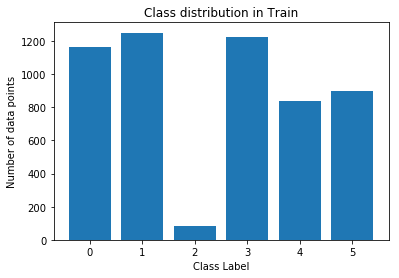

In [45]:
plt.bar(class_count.keys(), class_count.values())
plt.xlabel("Class Label")
plt.ylabel("Number of data points")
plt.title("Class distribution in Train")

In [46]:
classes = list(set(test_Y))
class_count = {}
for i in classes:
    class_count[int(i)] = sum(test_Y==i)
print class_count

{0: 138, 1: 94, 2: 9, 3: 65, 4: 81, 5: 113}


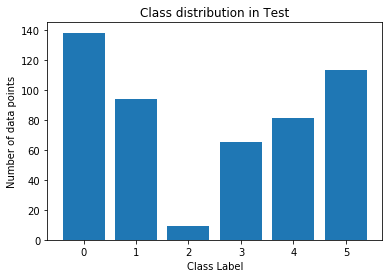

In [47]:
plt.bar(class_count.keys(), class_count.values())
plt.xlabel("Class Label")
plt.ylabel("Number of data points")
plt.title("Class distribution in Test")

In [187]:
#Increasing the value will increase sequence length in many sentences. Captures more words
TOP_N_WORDS = 6000
#TOP_N_WORDS = 8459

In [188]:
tokenizer = Tokenizer(nb_words=TOP_N_WORDS)
tokenizer.fit_on_texts(train_X)
sequences = tokenizer.texts_to_sequences(train_X)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8459 unique tokens.


In [189]:
for i in word_index:
    if word_index[i] == 0:
        print i

In [190]:
print train_X.iloc[1]
print sequences[1]

what films featured the character popeye doyle ?
[2, 802, 603, 1, 126, 1252, 3505]


In [191]:
max_sequence_length = 0
min_sequence_length = -1
j = -1
for i in sequences:
    seq_len = len(i)
    
    if min_sequence_length == -1:
        min_sequence_length = seq_len
        
    if seq_len > max_sequence_length:
        max_sequence_length = seq_len
    
    if seq_len < min_sequence_length and min_sequence_length!=-1:
        min_sequence_length = seq_len
        j = i
        
print min_sequence_length
print max_sequence_length

2
33


In [192]:
data = pad_sequences(sequences, maxlen=max_sequence_length)
import numpy as np
data_labels = to_categorical(np.asarray(train_Y))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', data_labels.shape)

('Shape of data tensor:', (5452, 33))
('Shape of label tensor:', (5452, 6))


In [193]:
import os
FastText_DIR = "/home/manoj/Dropbox/ML_in_CL/abhi/fastText/"
embeddings_index = {}
f = open(os.path.join(FastText_DIR, 'wiki.simple.vec'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print "Loaded "+str(len(embeddings_index))+" word embeddings from Fast Text"

Loaded 111050 word embeddings from Fast Text


In [194]:
EMBEDDING_DIM = len(embeddings_index["the"])
print EMBEDDING_DIM

300


In [195]:
#+1 for bias.
#len(word_index) because we have so many unique tokens after all the filtering.

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be random numbers.
        embedding_matrix[i] = embedding_vector

In [196]:
embedding_matrix.shape

(8460, 300)

In [197]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=True)

In [198]:
sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = (LSTM(300, return_sequences=True))(embedded_sequences)
# x = Dropout(0.5)(x)
# x = (LSTM(20, return_sequences=True))(x)
# x = Dropout(0.5)(x)
# x = (LSTM(10, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
#x = Dropout(0.5)(x)
x = Dense(6, activation="softmax")(x)

model = Model(sequence_input, x)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])


In [199]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 33)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 33, 300)           2538000   
_________________________________________________________________
lstm_22 (LSTM)               (None, 33, 300)           721200    
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 300)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 1806      
Total params: 3,261,006
Trainable params: 3,261,006
Non-trainable params: 0
_________________________________________________________________


In [204]:
file_path="val_loss.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", patience=20)


callbacks_list = [checkpoint, early] #early

In [205]:
performance = model.fit(data[0:4452], data_labels[0:4452],epochs=10, batch_size=128, 
                       validation_data= (data[4452:],data_labels[4452:]), callbacks=callbacks_list)

Train on 4452 samples, validate on 1000 samples
Epoch 1/10
4452/4452 [==============================] - 19s 4ms/step - loss: 0.9477 - acc: 0.6635 - val_loss: 0.7014 - val_acc: 0.7560

Epoch 00001: val_loss improved from inf to 0.70141, saving model to val_loss.best.hdf5
Epoch 2/10
4452/4452 [==============================] - 19s 4ms/step - loss: 0.5237 - acc: 0.8219 - val_loss: 0.5747 - val_acc: 0.7900

Epoch 00002: val_loss improved from 0.70141 to 0.57465, saving model to val_loss.best.hdf5
Epoch 3/10
4452/4452 [==============================] - 19s 4ms/step - loss: 0.3129 - acc: 0.9003 - val_loss: 0.4963 - val_acc: 0.8200

Epoch 00003: val_loss improved from 0.57465 to 0.49626, saving model to val_loss.best.hdf5
Epoch 4/10
4452/4452 [==============================] - 19s 4ms/step - loss: 0.2117 - acc: 0.9369 - val_loss: 0.4617 - val_acc: 0.8450

Epoch 00004: val_loss improved from 0.49626 to 0.46168, saving model to val_loss.best.hdf5
Epoch 5/10
4452/4452 [==========================

In [206]:
set(train_Y[4452:])

{'0', '1', '2', '3', '4', '5'}

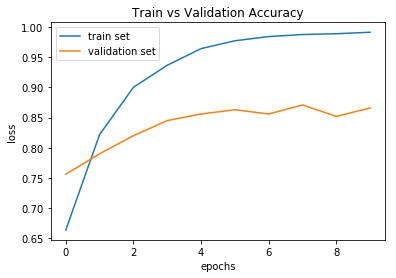

In [207]:
plt.plot(performance.history['acc'])
plt.plot(performance.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train set', 'validation set'], loc='best')
plt.title('Train vs Validation Accuracy')

In [219]:
#convert test data to sequences 
sequences = tokenizer.texts_to_sequences(test_X)
print len(sequences)

500


In [220]:
test_Y = to_categorical(np.asarray(test_Y))
print len(test_Y)

500


In [221]:
data_test = pad_sequences(sequences, maxlen=max_sequence_length)
data_test_labels = test_Y
print('Shape of data tensor:', data_test.shape)
print('Shape of label tensor:', data_test_labels.shape)

('Shape of data tensor:', (500, 33))
('Shape of label tensor:', (500, 6))


In [224]:
model.load_weights(file_path)

In [230]:
print "Test Accruracy:"+str(round(model.test_on_batch(data_test, data_test_labels)[1]*100,2))
print "Test Loss:"+str(model.test_on_batch(data_test, data_test_labels)[0])

Test Accruracy:87.0
Test Loss:0.3891631


In [223]:
model.metrics_names

['loss', 'acc']